<div class="alert alert-block alert-success" align = center>
<h1>XGBoost & CatBoost</h1>
</div>

Nel Notebook4 si è deciso di visualizzare l'effetto del dataset su librerie non viste a lezione.

In particolare si sono scelte
- XGBoost
- CatBoost

Si proveranno questi modelli su diversi dataset risultanti dai notebook precedenti.

In [1]:
import pandas as pd
import numpy as np

from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [2]:
#SPLIT TRAIN E TEST (80 - 20)
from sklearn.model_selection import train_test_split

def split(dataframe):
    
    # Si toglie la colonna da predire
    X = dataframe.drop(columns=['Sale_Price'], axis =1)

    # Si isola la colonna da predire
    y = dataframe['Sale_Price']

    X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)
    
    return X_train_80, X_test, y_train_80, y_test

In [3]:
def divide(dataframe):
    
    # Si separano le features dal prezzo
    X_train = dataframe.drop(columns = ['Sale_Price'], axis = 1)
    
    y_train = dataframe['Sale_Price']
    
    return X_train, y_train

Si importa il dataset sporco con outliers.

In [4]:
df = pd.read_csv('dataset_enc.csv')

In [5]:
X_train_80, X_test, y_train_80, y_test = split(df)

Si importa il dataset pulito su cui è stata applicata la tecnica dell'RFE con gli outliers.

In [6]:
df_clean = pd.read_csv('dataset_pulito.csv')

In [7]:
X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test = split(df_clean)

In [8]:
X_clean_train_80.shape

(2344, 238)

In [9]:
X_clean_test.shape

(586, 238)

Si importa il dataset senza encoding

In [10]:
df_no_enc = pd.read_csv('dataset_iniziale.csv')

In [11]:
X_no_enc_train, X_no_enc_test, y_no_enc_train, y_no_enc_test = split(df_no_enc)

Si importa il dataset pulito senza encoding prodotto nel Notebook2.

In [12]:
df_clean_no_enc = pd.read_csv('dataset_per_CatBoost.csv')

In [13]:
X_clean_no_enc_train, X_clean_no_enc_test, y_clean_no_enc_train, y_clean_no_enc_test = split(df_clean_no_enc)

<div class="alert alert-block alert-info" align = center>
    <h1>XGBoost</h1> 
</div>

XGBoost è una libreria open-source che sfrutta il gradient boosting per essere altamente efficente e veloce. 

I modelli che crea usano dei gradient boosting decision tree (GBDT). Essi implementano vari modelli più 'deboli' (ensemble learning) per poi confrontarli ed arrivare alla creazione di un modello migliore.

XGBoost accetta solo features numeriche, anche se, nelle ultime versioni si trova in fase di sperimentazione un algoritmo che accetta anche le feature categoriali.

I vantaggi nell'usare XGBoost sono:
- Migliori prestazioni grazie a calcoli più semplici;
- Si riesce a minimizzare l'errore in pochi passi.

Svantaggi:

- Performa male quando i dati sono molto sparsi;
- Molto sensibile agli outliers;
- Rischio di overfitting alto in caso di alberi troppo grandi.

I parametri che si possono andare a cambiare in un modello XGBoost sono:

- booster [default= gbtree ]; 
   + seleziona il booster da usare, può essere settato su: gbtree, gblinear or dart; gbtree e dart per modelli con alberi, mentre gblinear usa funzioni lineari.

- verbosity [default=1];

- Prolissità dei messaggi; 
    + I valori sono: 0 (silent), 1 (warning), 2 (info), 3 (debug). A volte XGBoost prova a cambiare la configuarzione e lo mostra tramite warning message. 

- validate_parameters [default to false, except for Python, R and CLI interface];
    + Quando impostato a _True_, XGBoost controllerà quale parametro di input è usato e quale no.

- nthread [default to maximum number of threads available if not set];

- Numero di thread paralleli utilizzati per eseguire il modello;

- disable_default_eval_metric [default= false];
    + Viene usata per disabilitare la metrica predefinita e per fare ciò è sufficiente impostare su 1 o true il valore.

- num_feature [set automatically by XGBoost, no need to be set by user]. 
    + Dimensione delle feature usate nel boosting.

> Quando si crea il modello si sceglie come obbiettivo 'reg:squarederror'.

Cambiando questo valore si può ottenere un modello che punta su altre misure dell'errore. 

Più tardi si proverà e farà il paragone sul dataset di base tra tutti i possibili parametri.

In [14]:
from sklearn.model_selection import RepeatedKFold
def elaborate(X_train, X_test, y_train, y_test):
    
    # Si crea il modello della regressione
    xgbr = XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
    xgbr.fit(X_train, y_train)
    
    # Si predice sul test
    pred = xgbr.predict(X_test)

    # RepeatedKFold serve per valutare lo score del modello    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    
    # Si valuta il modello
    scores = cross_val_score(xgbr, X_test, y_test, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)

    #dataframe per il confronto finale dei prezzi predetti
    dataframe_diff = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : pred, 'Difference' : abs(y_test - pred)})
    
    
    # Si ritornano i prezzi reali, quelli predetti, e gli scores.
    return y_test, pred, scores.mean(), scores.std(), dataframe_diff

In [15]:
def main(X_train, X_test, y_train, y_test):
    
    # Si elaborano i dati sui dataframe
    y_test, pred, scores_mean, scores_std, dataframe_diff = elaborate(X_train, X_test, y_train, y_test)  
    
    # Si stampa la differenza tra valori effettivi e predetti e plotto i grafici
    diff_pred_train = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : pred, 'Difference' : y_test - pred})
    
    # Si calcola lo score del modello
    MAE_test =mean_absolute_error(y_true = y_test, y_pred = pred)
    score = r2_score(y_test, pred)
    score_mean = scores_mean
    score_std = scores_std
    
    # Grafici
    fig, ax = plt.subplots()
    ax.scatter(y_test, pred, label = 'df')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    
    return MAE_test, score, score_mean, score_std, dataframe_diff

Esecuzione sul dataset iniziale 

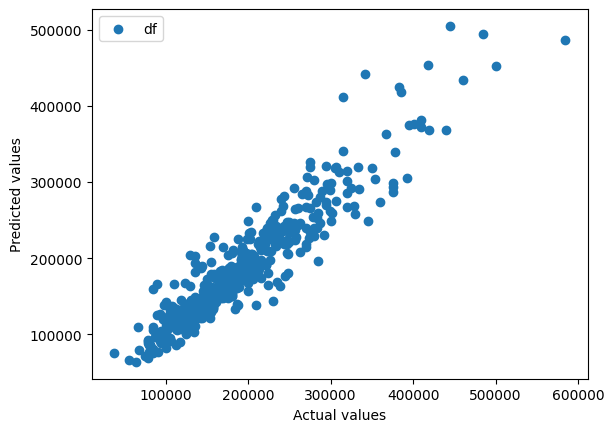

In [16]:
MAE, score, score_mean, score_std, dataframe_diff = main(X_train_80, X_test, y_train_80, y_test)

In [17]:
print("Errore: ", MAE)
print("Score: ", score)
print("Media e standard deviation: ", score_mean, score_std)

Errore:  17504.096416382254
Score:  0.8843918096271353
Media e standard deviation:  -20959.08166296056 3679.4650023446743


Si prova sul dataset pulito.

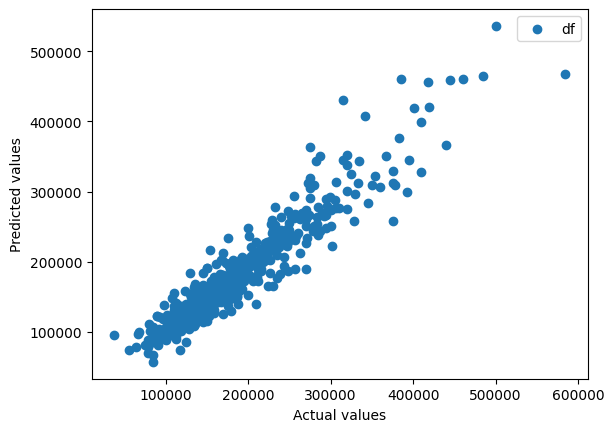

In [18]:
MAE_clean, score_clean, score_mean_clean, score_std_clean, dataframe_confronto = main(X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test)

In [19]:
print("Errore: ", MAE_clean)
print("Score: ", score_clean)
print("Media e standard deviation: ", score_mean_clean, score_std_clean)

Errore:  16721.50079324872
Score:  0.8936747416382483
Media e standard deviation:  -19063.692109725063 3302.0184827375383


In [20]:
print("Lo score sul dataset iniziale è: ", score)
print("Lo score sul dataset pulito è: ", score_clean)

Lo score sul dataset iniziale è:  0.8843918096271353
Lo score sul dataset pulito è:  0.8936747416382483


Si esporta il dataframe con le predizioni sul dataset pulito

In [21]:
dataframe_confronto = pd.concat([X_clean_test, dataframe_confronto], axis = 1)
dataframe_confronto.to_csv(r'df_confronto_XGB.csv', index = False)

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Come si nota dallo score, il dataset pulito ha prestazioni migliori rispetto al dataset iniziale (0.88439 contro 0.89367). Si evidenzia ancora una volta che il lavoro di pulizia ha portato a un miglioramento nelle predizioni da parte dei modelli. 

<div class="alert alert-block alert-info" align = center>
    <h1>Importanza delle feature</h1>
</div>

XGBoost permette di vedere l'importanza delle feature nella predizione del modello.
Questa importanza è calcolata grazie ai boosted decision trees, andando a calcolare quanto una feature influisca su di essi riuscendo così a ordinarli.

In [22]:
def feature_importance(X_train, X_test, y_train, y_test):
    
    # Encoding
    encoder = ce.LeaveOneOutEncoder(return_df=True)
    X_train_New = encoder.fit_transform(X_train, y_train)
    X_test_New = encoder.transform(X_test)
    
    # Si crea un modello sul quale calcolare l'mae
    model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
    model.fit(X_train_New, y_train)
    
    # Predizione
    y_pred = model.predict(np.ascontiguousarray(X_test_New))
    MAE = mean_absolute_error(y_test, y_pred)
    
    #grazie a feature_importance si crea un grafico per visualizzare le feature più rilevanti
    feature_importance = model.feature_importances_
    
    #ordine lo feature per importanza
    sorted_idx = np.argsort(feature_importance)
    
    #prendo le 10 migliori
    best_10 = sorted_idx[:10]
    
    # Grafico
    fig = plt.figure(figsize=(8, 8))
    plt.barh(range(len(best_10)), feature_importance[best_10], align='center')
    plt.yticks(range(len(best_10)), np.array(X_test.columns)[best_10])
    plt.title('Best Feature Importance')
    

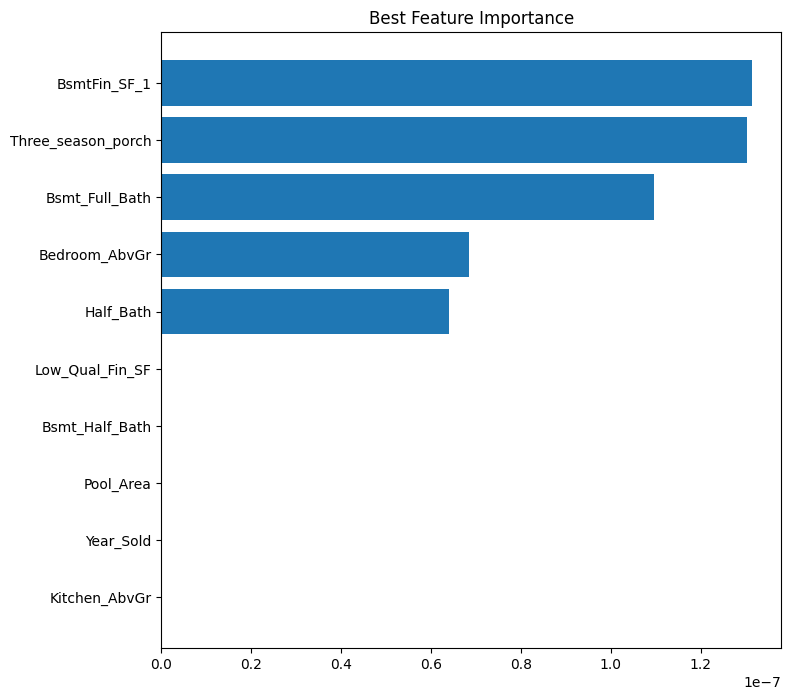

In [23]:
feature_importance(X_no_enc_train, X_no_enc_test, y_no_enc_train, y_no_enc_test)

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Le feature che il modello prende più in considerazione paiono essere il numero di bagni, la qualità delle camere, il porticato esterno e la superficie della cantina. 

Ciò che risalta molto è che dopo le prime 5 feature il punteggio va a 0.

Si prova ora sul dataset pulito per vedere eventuali differenze.

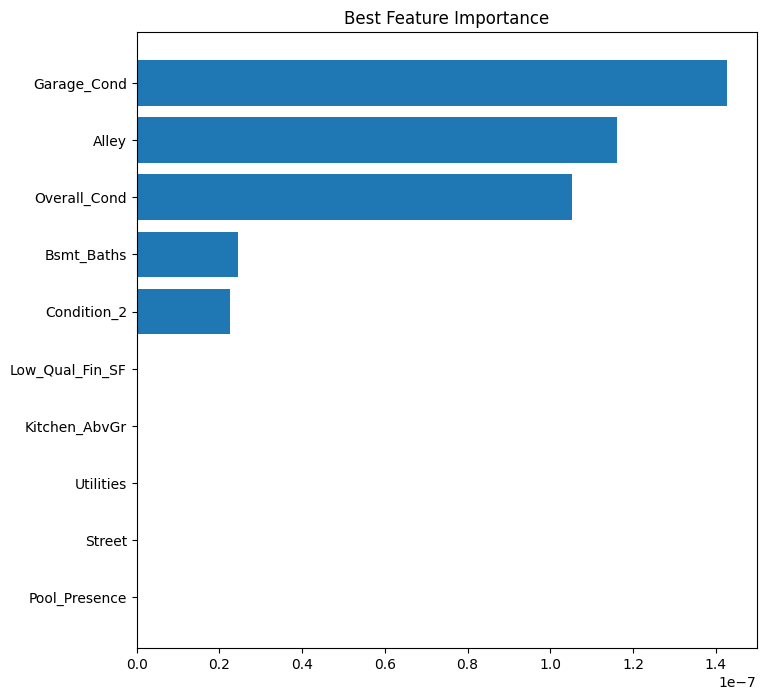

In [24]:
feature_importance(X_clean_no_enc_train, X_clean_no_enc_test, y_clean_no_enc_train, y_clean_no_enc_test)

Si fa ora il confronto dei modelli cambiando l'obiettivo.

Data la grande quantità di possibili `objective` se ne selezioneranno solo alcuni.

In [25]:
from sklearn.model_selection import RepeatedKFold
def elaborate_different(X_train, X_test, y_train, y_test, obj):
    
    # Si crea il modello della regressione
    xgbr = XGBRegressor(objective = obj , n_estimators = 10, seed = 123)
    xgbr.fit(X_train, y_train)
    
    # Si predice sul test
    pred = xgbr.predict(X_test)
    
    # RepeatedKFold serve per valutare lo score del modello
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    
    # Si valuta il modello
    scores = cross_val_score(xgbr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    return y_train, pred, scores.mean(), scores.std()

In [26]:
def main(X_train, X_test, y_train, y_test):
    
    
    obj = ['reg:squarederror', 'reg:squaredlogerror',  'count:poisson', 'reg:pseudohubererror']
    
    # Array di supporto
    scores_mean_array = []
    scores_std_array = []
    
    # Per ogni diverso obiettivo
    for i in obj:
        
        y_train, pred, score_mean, score_std= elaborate_different(X_train, X_test, y_train, y_test, i)
        scores_mean_array.append(score_mean)
        scores_std_array.append(score_std)
    j = 0
    
    return obj, scores_mean_array, scores_std_array

In [27]:
obj, scores_mean, scores_std = main(X_train_80, X_test, y_train_80, y_test)

Ora si visualizzano i risultati

In [28]:
j = 0
for i in obj:
    print("per l'obiettivo {}\n     lo score_mean è: {}\n     lo score_std è {}".format(i, scores_mean[j], scores_std[j]))
    j += 1

per l'obiettivo reg:squarederror
     lo score_mean è: -18134.515111975852
     lo score_std è 1438.8835229263148
per l'obiettivo reg:squaredlogerror
     lo score_mean è: -180606.701844034
     lo score_std è 5009.407835819416
per l'obiettivo count:poisson
     lo score_mean è: -180618.4246795112
     lo score_std è 5009.407056982596
per l'obiettivo reg:pseudohubererror
     lo score_mean è: -180622.00776504815
     lo score_std è 5009.407056982596


Si prova anche sul dataset pulito.

In [29]:
obj_clean, scores_mean_clean, scores_std_clean = main(X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test)

In [30]:
j = 0
for i in obj_clean:
    print("per l'obiettivo {}\n     lo score_mean è: {}\n     lo score_std è {}".format(i, scores_mean_clean[j], scores_std_clean[j]))
    j += 1

per l'obiettivo reg:squarederror
     lo score_mean è: -17424.05783639402
     lo score_std è 1112.4497700673369
per l'obiettivo reg:squaredlogerror
     lo score_mean è: -180606.701844034
     lo score_std è 5009.407835819416
per l'obiettivo count:poisson
     lo score_mean è: -180618.4246795112
     lo score_std è 5009.407056982596
per l'obiettivo reg:pseudohubererror
     lo score_mean è: -180622.00776504815
     lo score_std è 5009.407056982596


Da questi risultati si nota come la predizione sia molto migliore con _reg:squarederror_ come obiettivo. 

<div class="alert alert-block alert-info" align = "center">
    <h1>CatBoost</h1> 
</div>

Catboost è una libreria open source ad alte prestazioni per il potenziamento del gradiente sugli __alberi decisionali__.

Crea modelli __target-based__, ovvero cerca di capire l’impatto del valore della singola feature sulla colonna target, che in questo caso è `Sale_Price`.

Tale libreria accetta in input 3 diverse tipologie di features:
- features composte da testo
- features numeriche
- features categoriali

Per quest'ultimo caso è bene passare un vettore che indichi l'indice delle features categoriali.

I vantaggi di questa libreria sono:
> Riduce il tempo dedicato all'ottimizzazione dei parametri, perché CatBoost fornisce ottimi risultati con parametri predefiniti;

> Migliora i risultati dell' allenamento così da consentire l'utilizzo di fattori non numerici, invece di dover pre-elaborare il dataset o dedicare tempo e fatica a trasformarli in numeri;

> Riduce l'overfitting durante la costruzione dei modelli con un nuovo schema di potenziamento del gradiente.

Visto che il dataset fornito contiene features categoriali, viene qui di seguito implementata una funzione in grado di individuarne gli indici.

In [31]:
# Funzione che estrapola gli indici delle feature categoriali
def index_str(columns, values):
    temp = []
    temp_names = []
    for i in range(len(values)):
        if isinstance(values[i], str):
            temp.append(i)
            temp_names.append(columns[i])
    return temp_names

Risulta necessario che tutte le features categoriali vengono 'castate' a 'category'.

In [32]:
def convert_category(dataframe, names):
    n_rows, n_cols = dataframe.shape
    j = 0
    i = 0
    while(j < len(names)):
        if (dataframe.columns[i] == names[j]):
            col = names[j]
            dataframe[col] = dataframe[col].astype('category')
            j += 1
        i += 1

In [33]:
def data_preparation(dataframe):
    
    columns_names = np.array(dataframe.columns)
    first_values = np.array(dataframe.iloc[0])
    categorical_features_names = index_str(columns_names, first_values)
    
    return categorical_features_names

In [34]:
def Cat_Boost(X_train, X_test, y_train, y_test, categorical_features):
    
    # Vengono create delle Pool per facilitare l'esecuzione
    X_train_dataset = cb.Pool(X_train, y_train, cat_features = categorical_features)
    X_test_dataset = cb.Pool(X_test, y_test, cat_features = categorical_features)
    
    # Creazione del modello
    catboost_model = cb.CatBoostRegressor()
    catboost_model.fit(X_train, y_train, cat_features = categorical_features)
    
    # Calcolo dello score (metodo di CatBoost) su train e test e dell'errore assoluto per il test-set
    y_pred = catboost_model.predict(X_test)
    SCORE_train = catboost_model.score(X_train, y_train)
    SCORE_test = catboost_model.score(X_test, y_test)
    MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_pred)
    
    INFO = [SCORE_train, SCORE_test, MAE_test]
    
    # Recupero delle feature più importanti
    f_i = catboost_model.feature_importances_
    f_i = f_i[-10:]
    
    # Grafico 
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')


    #dataframe per il confronto delle predizioni
    dataframe_diff = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : y_pred, 'Difference' : abs(y_test - y_pred)})
    
    return INFO, f_i, dataframe_diff

In [35]:
categorical_features = data_preparation(df_no_enc)

Learning rate set to 0.046842
0:	learn: 78660.6270754	total: 208ms	remaining: 3m 28s
1:	learn: 76198.4361260	total: 256ms	remaining: 2m 7s
2:	learn: 74007.8651315	total: 297ms	remaining: 1m 38s
3:	learn: 71921.6575785	total: 346ms	remaining: 1m 26s
4:	learn: 69959.2798269	total: 407ms	remaining: 1m 20s
5:	learn: 68001.0472527	total: 453ms	remaining: 1m 15s
6:	learn: 66200.8293469	total: 509ms	remaining: 1m 12s
7:	learn: 64291.1216423	total: 574ms	remaining: 1m 11s
8:	learn: 62647.4680592	total: 633ms	remaining: 1m 9s
9:	learn: 60848.7687827	total: 679ms	remaining: 1m 7s
10:	learn: 59235.6819547	total: 741ms	remaining: 1m 6s
11:	learn: 57591.5578462	total: 821ms	remaining: 1m 7s
12:	learn: 56126.4224662	total: 904ms	remaining: 1m 8s
13:	learn: 54731.7491869	total: 988ms	remaining: 1m 9s
14:	learn: 53304.0659726	total: 1.06s	remaining: 1m 9s
15:	learn: 52081.2006451	total: 1.12s	remaining: 1m 8s
16:	learn: 50902.7564178	total: 1.2s	remaining: 1m 9s
17:	learn: 49717.4224919	total: 1.27s	r

150:	learn: 19574.6962150	total: 10.7s	remaining: 1m
151:	learn: 19555.1338757	total: 10.8s	remaining: 1m
152:	learn: 19484.1287519	total: 10.8s	remaining: 60s
153:	learn: 19437.3005377	total: 10.9s	remaining: 59.8s
154:	learn: 19388.3129410	total: 11s	remaining: 59.9s
155:	learn: 19338.4465562	total: 11.1s	remaining: 59.8s
156:	learn: 19281.3340490	total: 11.1s	remaining: 59.9s
157:	learn: 19221.4268049	total: 11.2s	remaining: 59.8s
158:	learn: 19198.6613481	total: 11.3s	remaining: 59.6s
159:	learn: 19160.9012747	total: 11.3s	remaining: 59.5s
160:	learn: 19120.5595724	total: 11.4s	remaining: 59.5s
161:	learn: 19087.6699218	total: 11.5s	remaining: 59.6s
162:	learn: 19048.5188205	total: 11.6s	remaining: 59.6s
163:	learn: 19023.1283152	total: 11.7s	remaining: 59.5s
164:	learn: 18987.8125125	total: 11.7s	remaining: 59.4s
165:	learn: 18971.8805021	total: 11.8s	remaining: 59.3s
166:	learn: 18938.3228458	total: 11.9s	remaining: 59.2s
167:	learn: 18897.8060803	total: 11.9s	remaining: 59s
168:

300:	learn: 15545.3062196	total: 21.3s	remaining: 49.4s
301:	learn: 15535.5267689	total: 21.3s	remaining: 49.3s
302:	learn: 15532.6487669	total: 21.4s	remaining: 49.2s
303:	learn: 15522.5759808	total: 21.5s	remaining: 49.1s
304:	learn: 15517.9401409	total: 21.5s	remaining: 49.1s
305:	learn: 15485.8202158	total: 21.6s	remaining: 49s
306:	learn: 15467.4997428	total: 21.7s	remaining: 49s
307:	learn: 15445.2317546	total: 21.8s	remaining: 49s
308:	learn: 15428.1955242	total: 21.9s	remaining: 48.9s
309:	learn: 15385.5060054	total: 21.9s	remaining: 48.8s
310:	learn: 15351.1586714	total: 22s	remaining: 48.7s
311:	learn: 15332.5719846	total: 22.1s	remaining: 48.7s
312:	learn: 15323.9374408	total: 22.1s	remaining: 48.5s
313:	learn: 15315.6499207	total: 22.2s	remaining: 48.5s
314:	learn: 15287.7788640	total: 22.3s	remaining: 48.5s
315:	learn: 15263.3484744	total: 22.4s	remaining: 48.4s
316:	learn: 15230.4174892	total: 22.4s	remaining: 48.4s
317:	learn: 15199.0402628	total: 22.5s	remaining: 48.2s


449:	learn: 13470.3552477	total: 31.5s	remaining: 38.5s
450:	learn: 13468.4768134	total: 31.6s	remaining: 38.5s
451:	learn: 13462.0438120	total: 31.7s	remaining: 38.4s
452:	learn: 13461.3572559	total: 31.8s	remaining: 38.4s
453:	learn: 13457.3370981	total: 31.9s	remaining: 38.3s
454:	learn: 13441.2966380	total: 31.9s	remaining: 38.2s
455:	learn: 13423.3721845	total: 32s	remaining: 38.2s
456:	learn: 13420.3494235	total: 32.1s	remaining: 38.1s
457:	learn: 13413.5346378	total: 32.2s	remaining: 38.1s
458:	learn: 13406.6101726	total: 32.3s	remaining: 38s
459:	learn: 13400.7540604	total: 32.3s	remaining: 38s
460:	learn: 13394.9320101	total: 32.4s	remaining: 37.9s
461:	learn: 13361.2781459	total: 32.4s	remaining: 37.8s
462:	learn: 13337.6574988	total: 32.5s	remaining: 37.7s
463:	learn: 13328.9546154	total: 32.5s	remaining: 37.6s
464:	learn: 13300.4146276	total: 32.6s	remaining: 37.5s
465:	learn: 13284.4272153	total: 32.7s	remaining: 37.4s
466:	learn: 13259.2392744	total: 32.7s	remaining: 37.4

599:	learn: 11896.4066874	total: 42.9s	remaining: 28.6s
600:	learn: 11892.6357475	total: 43s	remaining: 28.6s
601:	learn: 11883.2152410	total: 43.1s	remaining: 28.5s
602:	learn: 11878.9597797	total: 43.2s	remaining: 28.4s
603:	learn: 11871.8798387	total: 43.3s	remaining: 28.4s
604:	learn: 11849.6165590	total: 43.3s	remaining: 28.3s
605:	learn: 11847.5395933	total: 43.4s	remaining: 28.2s
606:	learn: 11824.8691880	total: 43.5s	remaining: 28.2s
607:	learn: 11810.3418995	total: 43.6s	remaining: 28.1s
608:	learn: 11795.1448182	total: 43.6s	remaining: 28s
609:	learn: 11794.2066389	total: 43.7s	remaining: 27.9s
610:	learn: 11792.4091368	total: 43.8s	remaining: 27.9s
611:	learn: 11774.6887398	total: 43.8s	remaining: 27.8s
612:	learn: 11758.5119668	total: 43.9s	remaining: 27.7s
613:	learn: 11756.5781983	total: 44s	remaining: 27.6s
614:	learn: 11752.4685333	total: 44.1s	remaining: 27.6s
615:	learn: 11742.8230232	total: 44.1s	remaining: 27.5s
616:	learn: 11732.6157324	total: 44.2s	remaining: 27.4

747:	learn: 10717.1360189	total: 53.5s	remaining: 18s
748:	learn: 10716.2904788	total: 53.6s	remaining: 18s
749:	learn: 10713.9813894	total: 53.7s	remaining: 17.9s
750:	learn: 10708.7215559	total: 53.7s	remaining: 17.8s
751:	learn: 10694.1913584	total: 53.8s	remaining: 17.7s
752:	learn: 10689.0012481	total: 53.9s	remaining: 17.7s
753:	learn: 10675.2390289	total: 54s	remaining: 17.6s
754:	learn: 10668.6762457	total: 54s	remaining: 17.5s
755:	learn: 10659.8169436	total: 54.1s	remaining: 17.5s
756:	learn: 10647.1661631	total: 54.2s	remaining: 17.4s
757:	learn: 10645.3452586	total: 54.3s	remaining: 17.3s
758:	learn: 10645.1452648	total: 54.4s	remaining: 17.3s
759:	learn: 10639.8471857	total: 54.4s	remaining: 17.2s
760:	learn: 10633.8519736	total: 54.5s	remaining: 17.1s
761:	learn: 10627.3928208	total: 54.6s	remaining: 17s
762:	learn: 10624.8268932	total: 54.6s	remaining: 17s
763:	learn: 10612.2098604	total: 54.7s	remaining: 16.9s
764:	learn: 10601.5907759	total: 54.7s	remaining: 16.8s
765:

898:	learn: 9731.4075677	total: 1m 4s	remaining: 7.26s
899:	learn: 9723.6950542	total: 1m 4s	remaining: 7.19s
900:	learn: 9718.7233862	total: 1m 4s	remaining: 7.12s
901:	learn: 9712.3394681	total: 1m 4s	remaining: 7.04s
902:	learn: 9709.9213879	total: 1m 4s	remaining: 6.97s
903:	learn: 9701.9153446	total: 1m 4s	remaining: 6.9s
904:	learn: 9696.7464006	total: 1m 5s	remaining: 6.83s
905:	learn: 9693.1392352	total: 1m 5s	remaining: 6.76s
906:	learn: 9686.4485627	total: 1m 5s	remaining: 6.69s
907:	learn: 9679.1056702	total: 1m 5s	remaining: 6.62s
908:	learn: 9671.4087669	total: 1m 5s	remaining: 6.55s
909:	learn: 9670.1643361	total: 1m 5s	remaining: 6.47s
910:	learn: 9665.5154235	total: 1m 5s	remaining: 6.4s
911:	learn: 9664.0253695	total: 1m 5s	remaining: 6.33s
912:	learn: 9663.5922746	total: 1m 5s	remaining: 6.26s
913:	learn: 9658.7027412	total: 1m 5s	remaining: 6.19s
914:	learn: 9658.2967871	total: 1m 5s	remaining: 6.12s
915:	learn: 9653.5266925	total: 1m 5s	remaining: 6.05s
916:	learn: 

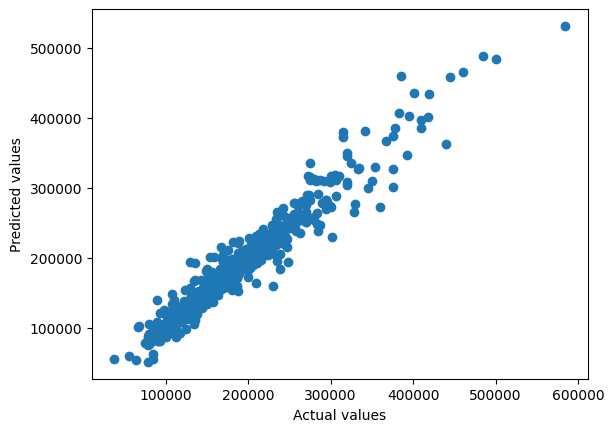

In [36]:
INFO, features_importance, dataframe_confronto = Cat_Boost(X_no_enc_train, X_no_enc_test, y_no_enc_train, y_no_enc_test, categorical_features)

L'andamento è abbastanza lineare!

In [37]:
print("Score train: ", INFO[0])
print("Score test: ", INFO[1])
print("Errore: ", INFO[2])

Score train:  0.984062050405936
Score test:  0.9399865525026874
Errore:  12513.18165511656


Si prova anche sul dataset pulito prodotto nel Notebook2.

In [38]:
categorical_features_clean = data_preparation(df_clean_no_enc)

Learning rate set to 0.046842
0:	learn: 78468.2444701	total: 30.5ms	remaining: 30.5s
1:	learn: 75931.1253885	total: 62.8ms	remaining: 31.3s
2:	learn: 73506.5656316	total: 98.8ms	remaining: 32.8s
3:	learn: 71240.2299565	total: 142ms	remaining: 35.4s
4:	learn: 69199.8122772	total: 188ms	remaining: 37.4s
5:	learn: 66996.8202572	total: 249ms	remaining: 41.2s
6:	learn: 64954.6410237	total: 305ms	remaining: 43.2s
7:	learn: 63112.6027375	total: 365ms	remaining: 45.3s
8:	learn: 61249.1382352	total: 425ms	remaining: 46.8s
9:	learn: 59516.9257157	total: 493ms	remaining: 48.8s
10:	learn: 57953.8592120	total: 552ms	remaining: 49.6s
11:	learn: 56369.5458786	total: 618ms	remaining: 50.8s
12:	learn: 54755.6122550	total: 683ms	remaining: 51.8s
13:	learn: 53379.6173443	total: 737ms	remaining: 51.9s
14:	learn: 52038.3282465	total: 787ms	remaining: 51.7s
15:	learn: 50700.0488888	total: 847ms	remaining: 52.1s
16:	learn: 49458.6388164	total: 910ms	remaining: 52.6s
17:	learn: 48353.3143559	total: 973ms	rema

149:	learn: 18672.2373580	total: 7.97s	remaining: 45.2s
150:	learn: 18656.3147043	total: 8.02s	remaining: 45.1s
151:	learn: 18624.9099135	total: 8.08s	remaining: 45.1s
152:	learn: 18595.2087020	total: 8.13s	remaining: 45s
153:	learn: 18560.4837440	total: 8.17s	remaining: 44.9s
154:	learn: 18508.0581463	total: 8.21s	remaining: 44.8s
155:	learn: 18474.8507533	total: 8.24s	remaining: 44.6s
156:	learn: 18430.2061760	total: 8.28s	remaining: 44.4s
157:	learn: 18416.1440438	total: 8.31s	remaining: 44.3s
158:	learn: 18390.7115641	total: 8.35s	remaining: 44.2s
159:	learn: 18355.5675119	total: 8.4s	remaining: 44.1s
160:	learn: 18313.7729445	total: 8.46s	remaining: 44.1s
161:	learn: 18280.3926476	total: 8.51s	remaining: 44s
162:	learn: 18244.2023357	total: 8.55s	remaining: 43.9s
163:	learn: 18203.1361675	total: 8.58s	remaining: 43.7s
164:	learn: 18179.7955652	total: 8.61s	remaining: 43.6s
165:	learn: 18143.7727516	total: 8.65s	remaining: 43.4s
166:	learn: 18104.2183312	total: 8.7s	remaining: 43.4

300:	learn: 14994.4870904	total: 15.8s	remaining: 36.6s
301:	learn: 14976.0622422	total: 15.8s	remaining: 36.6s
302:	learn: 14964.1020501	total: 15.9s	remaining: 36.5s
303:	learn: 14943.4061470	total: 15.9s	remaining: 36.5s
304:	learn: 14926.8833937	total: 16s	remaining: 36.4s
305:	learn: 14917.7055267	total: 16s	remaining: 36.4s
306:	learn: 14896.4881875	total: 16.1s	remaining: 36.3s
307:	learn: 14882.9553035	total: 16.1s	remaining: 36.2s
308:	learn: 14867.7851199	total: 16.1s	remaining: 36.1s
309:	learn: 14838.8450078	total: 16.2s	remaining: 36.1s
310:	learn: 14836.0725854	total: 16.3s	remaining: 36s
311:	learn: 14817.0352506	total: 16.3s	remaining: 36s
312:	learn: 14806.8636464	total: 16.4s	remaining: 35.9s
313:	learn: 14777.8680676	total: 16.4s	remaining: 35.9s
314:	learn: 14769.6704175	total: 16.5s	remaining: 35.9s
315:	learn: 14767.1849358	total: 16.5s	remaining: 35.8s
316:	learn: 14746.5842553	total: 16.6s	remaining: 35.8s
317:	learn: 14740.3871367	total: 16.6s	remaining: 35.7s


448:	learn: 13316.5822937	total: 23.7s	remaining: 29.1s
449:	learn: 13308.8753588	total: 23.7s	remaining: 29s
450:	learn: 13291.2959154	total: 23.8s	remaining: 28.9s
451:	learn: 13279.7895820	total: 23.8s	remaining: 28.9s
452:	learn: 13268.8015929	total: 23.9s	remaining: 28.8s
453:	learn: 13248.9898045	total: 24s	remaining: 28.8s
454:	learn: 13228.1618850	total: 24s	remaining: 28.8s
455:	learn: 13213.7747311	total: 24.1s	remaining: 28.7s
456:	learn: 13211.3167082	total: 24.1s	remaining: 28.6s
457:	learn: 13210.6861534	total: 24.2s	remaining: 28.6s
458:	learn: 13202.2079943	total: 24.2s	remaining: 28.6s
459:	learn: 13183.9678065	total: 24.3s	remaining: 28.5s
460:	learn: 13167.7031922	total: 24.4s	remaining: 28.5s
461:	learn: 13153.8637244	total: 24.5s	remaining: 28.5s
462:	learn: 13140.1813985	total: 24.6s	remaining: 28.5s
463:	learn: 13132.7864333	total: 24.6s	remaining: 28.4s
464:	learn: 13125.0635921	total: 24.7s	remaining: 28.4s
465:	learn: 13122.5306918	total: 24.7s	remaining: 28.4

598:	learn: 11960.2107176	total: 31.9s	remaining: 21.4s
599:	learn: 11953.2682261	total: 32s	remaining: 21.3s
600:	learn: 11940.2338789	total: 32s	remaining: 21.3s
601:	learn: 11935.7900724	total: 32.1s	remaining: 21.2s
602:	learn: 11934.1872646	total: 32.2s	remaining: 21.2s
603:	learn: 11926.1119592	total: 32.2s	remaining: 21.1s
604:	learn: 11917.4493994	total: 32.3s	remaining: 21.1s
605:	learn: 11900.0879479	total: 32.3s	remaining: 21s
606:	learn: 11897.0312081	total: 32.4s	remaining: 21s
607:	learn: 11888.4963303	total: 32.5s	remaining: 20.9s
608:	learn: 11877.0119388	total: 32.5s	remaining: 20.9s
609:	learn: 11864.7564553	total: 32.6s	remaining: 20.8s
610:	learn: 11849.8280568	total: 32.7s	remaining: 20.8s
611:	learn: 11844.1224521	total: 32.7s	remaining: 20.8s
612:	learn: 11837.9154243	total: 32.8s	remaining: 20.7s
613:	learn: 11824.2148824	total: 32.9s	remaining: 20.7s
614:	learn: 11815.5617184	total: 32.9s	remaining: 20.6s
615:	learn: 11791.7250652	total: 33s	remaining: 20.6s
61

748:	learn: 10750.5371642	total: 40.1s	remaining: 13.4s
749:	learn: 10744.1455950	total: 40.1s	remaining: 13.4s
750:	learn: 10730.2955148	total: 40.2s	remaining: 13.3s
751:	learn: 10728.4035080	total: 40.2s	remaining: 13.3s
752:	learn: 10726.3918433	total: 40.3s	remaining: 13.2s
753:	learn: 10722.3713404	total: 40.3s	remaining: 13.2s
754:	learn: 10720.7794558	total: 40.4s	remaining: 13.1s
755:	learn: 10719.8980348	total: 40.5s	remaining: 13.1s
756:	learn: 10710.7489074	total: 40.5s	remaining: 13s
757:	learn: 10704.0706549	total: 40.6s	remaining: 13s
758:	learn: 10694.3186828	total: 40.6s	remaining: 12.9s
759:	learn: 10680.3313976	total: 40.6s	remaining: 12.8s
760:	learn: 10677.8686821	total: 40.7s	remaining: 12.8s
761:	learn: 10673.5889341	total: 40.7s	remaining: 12.7s
762:	learn: 10670.1656405	total: 40.8s	remaining: 12.7s
763:	learn: 10666.7024115	total: 40.8s	remaining: 12.6s
764:	learn: 10647.5033492	total: 40.9s	remaining: 12.6s
765:	learn: 10639.9154276	total: 40.9s	remaining: 12

898:	learn: 9828.7070140	total: 47.1s	remaining: 5.29s
899:	learn: 9824.5229596	total: 47.1s	remaining: 5.24s
900:	learn: 9821.6492485	total: 47.2s	remaining: 5.18s
901:	learn: 9816.4406407	total: 47.2s	remaining: 5.13s
902:	learn: 9816.1479160	total: 47.3s	remaining: 5.08s
903:	learn: 9815.9215397	total: 47.4s	remaining: 5.03s
904:	learn: 9811.0566785	total: 47.4s	remaining: 4.98s
905:	learn: 9810.6972336	total: 47.5s	remaining: 4.93s
906:	learn: 9802.0161895	total: 47.6s	remaining: 4.88s
907:	learn: 9787.1239359	total: 47.7s	remaining: 4.83s
908:	learn: 9781.3977157	total: 47.7s	remaining: 4.78s
909:	learn: 9778.3398489	total: 47.8s	remaining: 4.72s
910:	learn: 9773.7589308	total: 47.8s	remaining: 4.67s
911:	learn: 9764.4453737	total: 47.9s	remaining: 4.63s
912:	learn: 9751.9468205	total: 48s	remaining: 4.57s
913:	learn: 9748.7750334	total: 48.1s	remaining: 4.52s
914:	learn: 9748.4807114	total: 48.2s	remaining: 4.47s
915:	learn: 9747.1920371	total: 48.2s	remaining: 4.42s
916:	learn: 

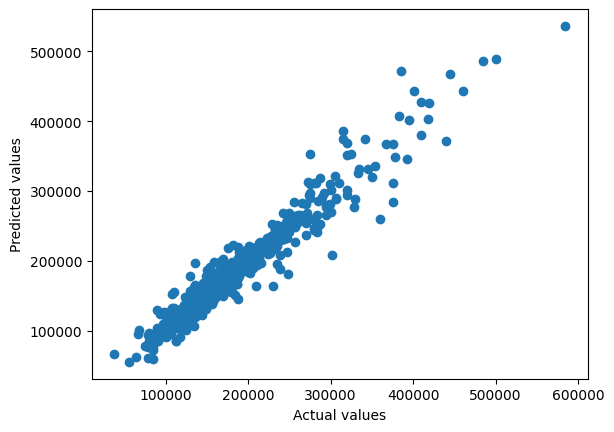

In [39]:
INFO_clean, features_importance_clean, dataframe_diff = Cat_Boost(X_clean_no_enc_train, X_clean_no_enc_test, y_clean_no_enc_train, y_clean_no_enc_test, categorical_features_clean)

In [40]:
print("Score train: ", INFO_clean[0])
print("Score test: ", INFO_clean[1])
print("Errore: ", INFO_clean[2])

Score train:  0.9844197741274726
Score test:  0.9388501357062311
Errore:  12184.390025740498


Si esporta ora il dataframe per il confronto finale

In [41]:
dataframe_confronto = pd.concat([X_clean_no_enc_test, dataframe_confronto], axis = 1)
dataframe_confronto.to_csv(r'df_confronto_CB.csv', index = False)

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

In questo caso si è predetto meglio (sul test-set), anche se di poco, sul dataset iniziale.

In [42]:
print("Lo score sul dataset sporco è: ", INFO[1])
print("Lo score sul dataset pulito è: ", INFO_clean[1])

Lo score sul dataset sporco è:  0.9399865525026874
Lo score sul dataset pulito è:  0.9388501357062311


<div class="alert alert-block alert-info" align = center>
    <h1>Importanza delle feature</h1>
</div>

Ora si prova a fare il grafico dell'importanza delle features (le 10 più importanti).

In [43]:
def plot_feature_importance(importance, names, model_type):

    # Array di supporto
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Nuovo dataframe per facilitare la rappresentazione
    data = {'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Ordinare i valori
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)

    # Grafico
    plt.figure(figsize = (10,8))
    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

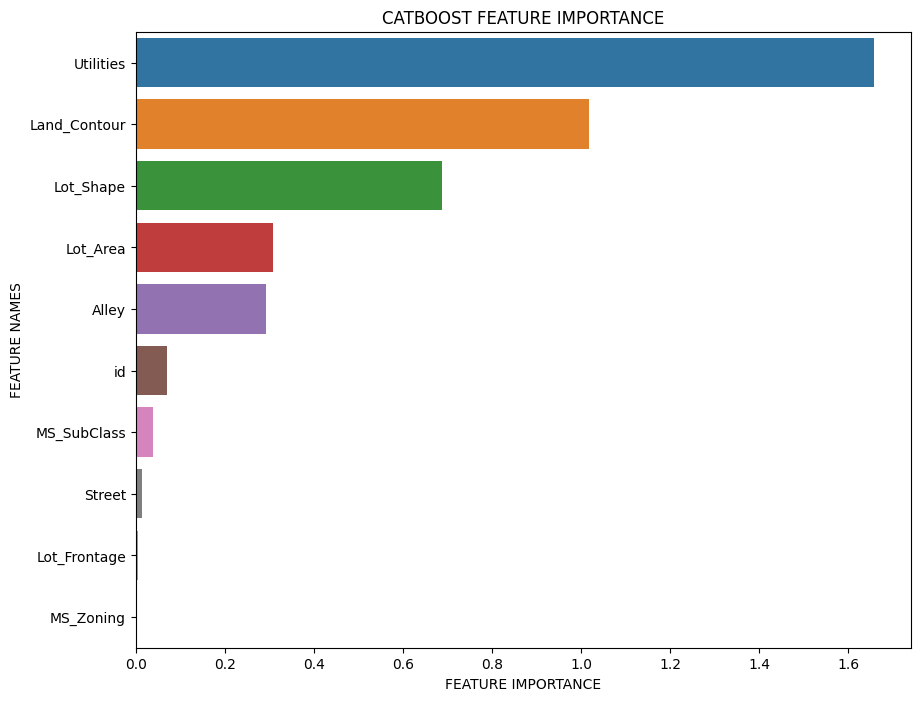

In [44]:
col = X_no_enc_train.columns[:10]
plot_feature_importance(features_importance, col, 'CATBOOST')

E per il dataset pulito.

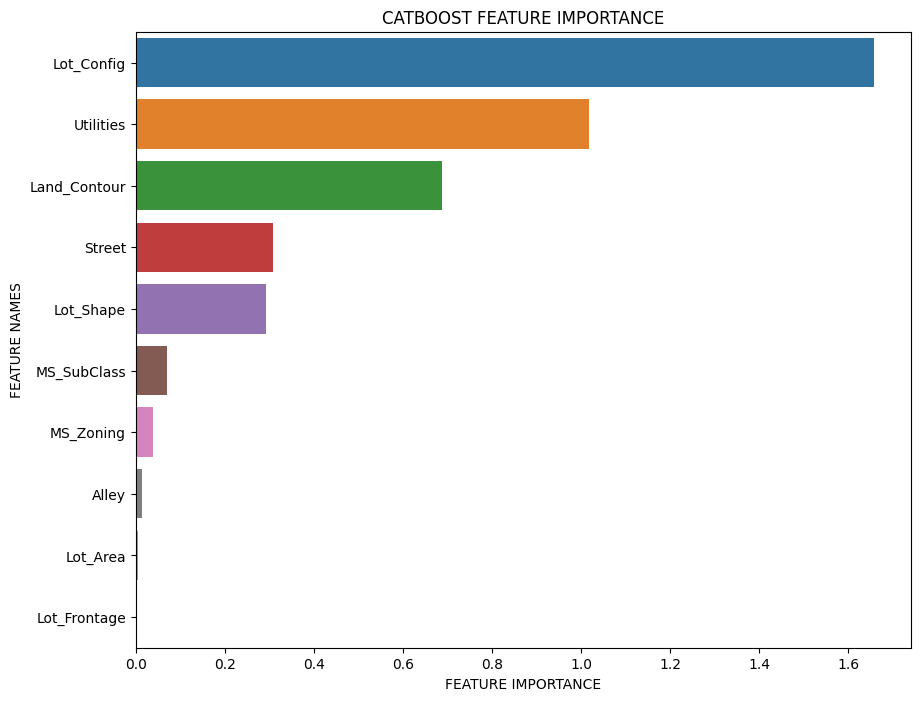

In [45]:
col = X_clean_no_enc_train.columns[:10]
plot_feature_importance(features_importance, col, 'CATBOOST')

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

come si può notare vi è una differenza tra i due grafici, infatti nel dataset sporco la feature più importante è `Utilities`, la quale perde, anche se poca, importanza nel dataset pulito cedendo il passo a `Lot_Config`. Vi sono anche altre divergenze tra i due grafici.

<div class="alert alert-block alert-warning">
<b>Considerazioni finali</b>
</div>

Tra i dataframe provati su XGBoost prevale il dataframe pulito.

Mentre tra i dataframe provati su CatBoost prevale (sul test-set) il dataframe iniziale.

Ma il più altro score (analogamente, il più basso errore) lo raggiunge CatBoost!

In [46]:
print("Lo score sul dataset pulito su XGBoost è: ", score_clean)
print("Lo score sul dataset pulito su CatBoost è: ", INFO[1])

Lo score sul dataset pulito su XGBoost è:  0.8936747416382483
Lo score sul dataset pulito su CatBoost è:  0.9399865525026874
